# Recap


In [91]:
import numpy as np
import matplotlib.pyplot as plt

## Recap en uitbreiding

Je hebt al gezien hoe je een botsend deeltjesmodel maakt. Je startte toen met 1 of 2 deeltjes en hebt dit uitgebreid naar ~100 deeltjes. Daarbij was het logisch om gebruik te maken van classes.

Voor het maken van een simulatie van gasmoleculen in een gesloten volume zal je logischerwijs de volgende stappen doorlopen:
1. bepalen van initiële condities
2. definiëren van de deeltjes
3. definiëren van volume met randvoorwaarden
4. simulaties bestaande uit:
    - bepaling van positie van deeltjes
    - controleren op onderlinge botsingen 
    - controleren op botsingen met wanden
    - aanpassen van eigenschappen zoals totaal volume of temperatuur
    - opslaan van gegevens
    
```{note}
Alhoewel het interessant is om steeds een animatie te maken van de beweging van de deeltjes, vraagt dit veel rekentijd. Je kan ook regelmatig een plot maken om te controleren of het programma werkt zoals je verwacht.
```

### De initiële condities

In onze simulatie gaan we uit van een aantal aannames. Bij deze aannames wil je dat de simulatie een voorspellende waarde heeft voor een reëel systeem, maar ook dat de benodigde rekenkracht voor het uitvoeren van de simulatie op te brengen is. We kiezen daarom voor de volgende condities:

- Ons model heeft een beperkt en constant aantal deeltjes.
- We maken gebruik van een 2D simulatie.
- De deeltjes voelen geen onderlinge kracht en ondergaan alleen elastische botsingen.
- (tijdens simuleren) De tijdstap is voldoende klein. (d.w.z. de afgelegde weg $v_0*dt$ is klein in vergelijking met de diameter van de deeltjes, zodat we geen botsingen missen)

Hieronder geven we een aantal constanten voor onze code. Om de simulatie straks te kunnen interpreteren, vergelijken we deze eerst met een realistische situatie:

```{exercise} Lucht in een fietsband
:label: ex-recap-1

Als model gaan we uit van een deel van het volume van een fietsband die onder een druk van 10 bar staat. Schat hiervoor het gemiddelde volume $V_{molecuul}$. Het antwoord gebruik je zo direct in de code hieronder. 
```

```{solution} ex-recap-1
Het gemiddelde volume per molecuul ($V_{molecuul}$) kan uitgerekend worden door gebruik te maken van de ideale gaswet (PV=NK_BT). Bij een kamertemperatuur van 20 graden(273.25+20 K), een druk van 10 bar (10^6Pa) en de constant van Boltzmann van 1.38*10^-23 is het gemiddelde volume per molecuul 4.04547e-27.

Op microscopische schaal wordt de gasconstante(R) vervangen door de constante van Boltzmann. De formule verandert dan van PV=nRT naar PV=Nk_BT.
```

De simulatie die we gaan maken bevat maar twee dimensies. We kunnen het oppervlak per deeltje in deze simulatie daarom kiezen als het zojuist berekende $V_{molecuul}^{2/3}$.

Voor de gemiddelde snelheid, $v$, van een molecuul geldt dat

$$
    \frac{1}{2}m\left< v^2\right> = \frac{f}{2} k_B T.
$$

Hierbij is $m$ de massa van het deeltje, $f$ het aantal dimensies, $k_B$ de constante van Boltzmann en $T$ de temperatuur.

```{exercise} Snelheid van een gasmolecuul
:label: ex-recap-2
Schat de snelheid van een gasmolecuul bij kamertemperatuur in twee dimensies. Ook deze heb je hierna nodig.
```

```{solution} ex-recap-2
Voor deze opdracht wordt het equipartitie-theorema voor twee dimensies gebruikt. Dit is de eerder aangegeven formule. Door de snelheid vrij te maken, wordt de formule: v=sqrt((f*K_B*T)/m). Met een aantal vrijheidsgraden (f) van 2 en een massa van ongeveer 4.65*10^-26 Kg, kan de gemiddelde snelheid berekend worden op 418.569 meters per seconde.

De massa van stikstof was in dit geval gebruikt omdat lucht voor ongeveer 78% uit stikstofgas bestaat. Daarnaast ligt de gemiddelde molaire massa van droge lucht (ongeveer 29u) zeer dicht bij de massa van stikstofmolecuul (ongeveer 28u). Daarom is het natuurkundig gezien de meeste logische keuze om een gemiddeld luchtmolecuul op deze manier te modelleren.
```

```{exercise} Radius
:label: ex-recap-3
Kies de eenheden waarin je de simulatie wilt gaan uitwerken. Dit kan in $\mathrm{m}$ maar ook in $\mathrm{mm}$ of iets anders. Pas de waardes voor de constanten `BOX_SIZE_0` en `V_0` in de hieronder gegeven code aan, zodat de simulatie een redelijk tweedimensionaal model is voor de fietsband. Hou hierbij het aantal deeltjes $N=40$ om de rekentijd van het model te beperken. Kies `RADIUS` gelijk aan 0.3 nm gebruik makend van jouw eenhedenstelsel.
```

```{solution} ex-recap-3
Parameters:
Aantal deeltjes = 40
Box_size_0=15.0 nanometers (nm)
V_0=0.42 nanometers per picoseconden (nm/ps)
Radius=0.3 nanometers (nm)
Delta =0.02 picoseconden (ps) 


```

```{exercise} DT
:label: ex-recap-4
Pas waarde van `DT` aan zodat de verplaatsing van een deeltje in een tijdstap klein genoeg is om te detecteren of deze met een ander deeltje botst. Zet in het groene commentaar bij elke constante in welk eenheid deze wordt weergegeven.
```

Onze simulatie modelleert dus een klein systeem zonder rekening te houden met de kracht tussen de luchtmoleculen. Je zult zien dat we toch al behoorlijk wat van de processor vragen om deze berekeningen te doen. Om een meer realistische modelsimulatie te maken is daarom een serieuze uitdaging, die veel wiskunde en programmeerervaring vraagt. Op dit ogenblik wordt dit bijvoorbeeld gevraagd bij een van de eerste opdrachten van het vak 'Computational Physics' van de master Applied Physics. 

In [92]:
#ex-recap-1
def v_mol(K_b,T,P):
    ans=(K_b*T)/P
    return(ans)
P=10*10**5
T=275.15+20 #Kamertemperatuur
#T_array=np.arange(0,30,15)+275.15

K_b= 1.38*10**-23 #Constante van Boltzmann

print('Het volume per molecuul is:',v_mol(K_b,T,P))

Het volume per molecuul is: 4.073069999999999e-27


In [93]:
#ex-recap-2

#Gegevens
m=(28*10**-3)/(6.022*10**23)
T=275.15+20
f=2 


def snelheid(T,K_b,m):
    return (np.sqrt((2*K_b*T)/m))
print('De gemiddelde snelheid is :',snelheid(T,K_b,m))



De gemiddelde snelheid is : 418.5692257133647


In [94]:
#ex-recap-3
nm=10**-9 #nanometers
ns=10**-9 #nanoseconden
Radius=0.3*nm
Total_Particles=40
N=Total_Particles
V_0= snelheid(T,K_b,m)*(nm/ns)


#The formule is V**(2/3)
oppervlakte_mol= v_mol(K_b,T,P)**(2/3)
print('De oppervlakte per molecuul is',oppervlakte_mol)

# Totale oppervlakte : Aantal deeltjes keer oppervlakte per molecuul.
Oppervlakte_Box= N*oppervlakte_mol
print('Oppervlakte van de Box',Oppervlakte_Box)

# Door de oppervlakte te beschouwen als een vierkant, wordt het eind resultaat Oppervlakte van het Box tot de macht 0.5 gedeeld door de nanometers.
Eind_Oppervlakte_box=(Oppervlakte_Box)**0.5/nm
print('Het eind resulaat is :', Eind_Oppervlakte_box) 

De oppervlakte per molecuul is 2.5504368968137226e-18
Oppervlakte van de Box 1.020174758725489e-16
Het eind resulaat is : 10.100370085920066


In [95]:
##ex-recap-4
#dt=v*DT - De afgelegd afstand van de deeltjes moet kleiner zijn dan hun diameter (2R)
#Dus DT < R/V_max(V_0)
Delta=(Radius/V_0)/ns
print('Delta in nanoseconden is',Delta)



Delta in nanoseconden is 0.0007167273214812007


In [96]:
# Ruimte voor uitwerking
BOX_SIZE_0 = 0                  # Hoogte en breedte startvolume (in vul je gekozen eenheid in)
N = 40                          # Aantal deeltjes 
V_0 = 0                         # Startsnelheid van deeltjes (vul je gekozen eenheid in)
RADIUS = 0                      # Straal van moleculen (vul je gekozen eenheid in)
DT = 0                          # Tijdstap om geen botsing te missen (vul je gekozen eenheid in)

In [66]:

print("--- Oefening 1 & 2: Schattingen ---")

# Constanten
kb = 1.38e-23  # Boltzmann constante (J/K)
T = 293        # Temperatuur (Kelvin)
P = 10e5       # Druk (10 bar in Pascal)
m_kg = 4.65e-26 # Massa N2 molecuul (kg)

# Ex-recap-1: Volume per molecuul
# PV = N kb T  ->  V/N = kb T / P
V_molecuul = (kb * T) / P
print(f"Schatting volume per molecuul: {V_molecuul:.2e} m^3")

# Ex-recap-2: Snelheid van een gasmolecuul (2D)
# 1/2 m <v^2> = f/2 kb T (met f=2) -> v = sqrt(2 kb T / m)
v_rms = np.sqrt(2 * kb * T / m_kg)
print(f"Schatting snelheid (v_rms): {v_rms:.1f} m/s")
print("-" * 40)

# =============================================================================
# 2. Constanten instellen (Recap 3 & 4)
# =============================================================================
# We kiezen voor eenheden die handig zijn op moleculaire schaal om afrondingsfouten te voorkomen:
# Lengte: nanometer (nm)
# Tijd: picoseconde (ps)
# Massa: Dalton (u)
# Snelheid: nm/ps (1 nm/ps = 1000 m/s)

# Conversie: 420 m/s = 0.42 nm/ps
# Radius: 0.3 nm

BOX_SIZE_0 = 15.0  # nm (Breedte van de doos)
N = 40             # Aantal deeltjes
V_0 = 0.42         # nm/ps (Startsnelheid)
RADIUS = 0.3       # nm (Straal van molecuul)
DT = 0.02          # ps (Tijdstap, klein genoeg zodat v*dt << RADIUS)

print("--- Oefening 3 & 4: Constanten ---")
print(f"Gekozen eenheden: nm, ps, u")
print(f"BOX_SIZE: {BOX_SIZE_0} nm")
print(f"DT: {DT} ps")
print("-" * 40)

--- Oefening 1 & 2: Schattingen ---
Schatting volume per molecuul: 4.04e-27 m^3
Schatting snelheid (v_rms): 417.0 m/s
----------------------------------------
--- Oefening 3 & 4: Constanten ---
Gekozen eenheden: nm, ps, u
BOX_SIZE: 15.0 nm
DT: 0.02 ps
----------------------------------------


### Particle class
Onze `ParticleClass` definieert van een deeltje de massa $m$, snelheid $v$, positie $r$, en straal $R$. De positie moet per tijdstap bepaald worden. 

Nieuw aan `ParticleClass` zijn twee properties, nl. `momentum` en `energy`. Een property is eigenlijk een variabele die samenhangt met de waarde van andere variabelen binnen de klasse. Om de interne consistentie te bewaren moet je de juiste waarde van deze variabele dus telkens afleiden en dat doe je met een functie. Zo geeft `kin_energy` de kinetische energie terug van het deeltje door die af te leiden van de variabelen `m` en `v`.

Buiten `ParticleClass` voegen we twee functies toe, die je ook al hebt gezien. De eerste heet `collide_detection` en detecteert of twee deeltjes onderling overlappen en dus botsen. De tweede heet `particle_collision` en berekent de nieuwe snelheden van de twee deeltjes ten gevolge van hun botsing.

In [67]:
# Maken van de class
class ParticleClass:
    def __init__(self, m, v, r, R):
        """ maakt een deeltje (constructor) """
        self.m = m                         
        self.v = np.array(v, dtype=float)  
        self.r = np.array(r, dtype=float)  
        self.R = R

    def update_position(self):
        """ verandert positie voor één tijdstap """
        self.r += self.v * DT 
            
    @property
    def momentum(self):
        return self.m * self.v
    
    @property
    def kin_energy(self):
        return 1/2 * self.m * np.dot(self.v, self.v)
    
def collide_detection(p1: ParticleClass, p2: ParticleClass) -> bool:
    """ Geeft TRUE als de deeltjes overlappen """
    """ Geeft TRUE als de deeltjes overlappen """
    dx = p1.r[0]-p2.r[0]
    dy = p1.r[1]-p2.r[1]
    rr = p1.R + p2.R
    return  dx**2+dy**2 < rr**2 
    #Note: np.linalg.norm(p1.r - p2.r) < (p1.R + p2.R) had ook gekund, maar is veel langzamer. Controleer zelf!

def particle_collision(p1: ParticleClass, p2: ParticleClass):
    """ past snelheden aan uitgaande van overlap """
    m1, m2 = p1.m, p2.m
    delta_r = p1.r - p2.r
    delta_v = p1.v - p2.v
    dot_product = np.dot(delta_r, delta_v)
    
    # Als deeltjes van elkaar weg bewegen dan geen botsing
    if dot_product >= 0: # '='-teken voorkomt ook problemen als delta_r == \vec{0}
        return
        
    distance_squared = np.dot(delta_r, delta_r) 
    # Botsing oplossen volgens elastische botsing in 2D
    p1.v -= 2 * m2 / (m1 + m2) * dot_product / distance_squared * delta_r
    p2.v += 2 * m1 / (m1 + m2) * dot_product / distance_squared * delta_r

### Volume en randvoorwaarden

Voor het volume maken we gebruik van het oppervlak van een `pyplot`, net zoals we dat in Q1 gedaan hebben. Daar is op dit ogenblik niets anders voor nodig dan een functie die de deeltjes laat botsen met de wanden.

Je hebt hiervoor al een voorbeeld van gezien, maar hieronder gebruiken we een andere vorm. Als je code ontwikkelt is het zaak om regelmatig en structureel te controleren of je code klopt. Het maakt daarbij niet uit of de code door jezelf is gemaakt, door een ander (zoals de docent) is aangeboden of van een generatieve AI komt. Hoe langer je code toevoegt zonder een controle uit te voeren, hoe groter de kans is dat je fout op fout stapelt en niet meer kan traceren wat er precies mis is. 

We maken gebruik van een truc die in veel simulaties wordt gebruikt: we maken gebruik van periodieke randvoorwaarden. In dit geval wil dit zeggen dat een deeltje dat botst met de wand aan de ene kant van het volume, aan de andere kant verschijnt met exact dezelfde snelheid. Op deze manier verandert de snelheid van een deeltje niet bij het botsen met de wand en blijven alle behoudswetten gelden. Die behoudswetten kunnen we straks goed controleren.

In [68]:
def box_collision(particle: ParticleClass):
    ''' botsing met wanden geeft periodieke randvoorwaarden '''
    for i in range(2):
        if particle.r[i] > BOX_SIZE_0 / 2:
            particle.r[i] -= BOX_SIZE_0 
        elif particle.r[i] < -BOX_SIZE_0 / 2:
            particle.r[i] += BOX_SIZE_0

### Maken van de simulatie

Nu dat we alle benodigde functies hebben, kunnen we ze in de juiste structuur zetten om de simulatie uit te voeren.

#### Bepaling positie deeltjes

Eerst moeten we alle deeltjes aanmaken en de startwaardes van hun variabelen invoeren:


```{exercise}
:label: const_speed
Leg uit dat d.m.v. onderstaande code de deeltjes allemaal dezelfde snelheid hebben en uniform verdeeld zijn over de box.
```

```{solution} const_speed
De totale snelheid van een deeltje wordt berekend met de stelling van Pythagoras. Uit de onderstaande code is er te lezen dat het v_x een willekeurige snelheid heeft en de V_y wordt berekend op basis van V_0 en V_x. Omdat v_y afhankelijk van v_x wordt berekend, is de optelsom van de vectoren altijd precies geljk aan V_0. Dus elk deeltje heeft exact dezelfde snelheid grootte, maar een willekeurig richting.  
```

In [69]:
def create_particles(particles):

    particles.clear
    for i in range(N):
        vx = np.random.uniform(-V_0, V_0)
        pos = np.random.uniform(-BOX_SIZE_0/2 + RADIUS, BOX_SIZE_0/2 - RADIUS, 2)
        particles.append(ParticleClass(m=1.0, v=[vx, vy], r=pos, R=RADIUS))

In [70]:
def create_particles(particles_list):

    particles_list.clear()
    for i in range(N):
        vx = np.random.uniform(-V_0,V_0)
        #-V_0 en V_0 zijn willekeurig punten tussen de waarden die straks gegeven zullen worden.
        # Het kan beschreven worden als de snelheid op de x-axes
        vy =np.random.choice([-1,1])*np.sqrt(V_0**2-vx**2)        
        #vy maakt gebruikt van de pythagoras theorem om de waardes uit te rekenen.
        # Door de gekozen methode is de absolute snelheid |V| altijd precies V0 
      
        #Positie
        pos = np.random.uniform(-BOX_SIZE_0/2 + RADIUS, BOX_SIZE_0/2 - RADIUS,2)
        particles_list.append(ParticleClass(m=1.0,v=[vx,vy],r=pos,R=RADIUS))



#### Controleren op onderlinge botsingen

Om de botsingen van alle deeltjes goed te verwerken moeten we controleren welke paren deeltjes met elkaar moeten botsen en deze botsingen één keer uitvoeren. 

```{exercise}
:label: double_loop
Leg uit hoe er in onderstaande code wordt voorkomen dat de botsing tussen twee deeltjes dubbel wordt uitgevoerd.
```

```{solution} double_loop
De code gebruikt een slimme techniek met twee lussen (loops) waarbij de tweede lus altijd een stapje verder begint dan de eerste:

De 'i + 1' techniek: De buitenste lus loopt over deeltje i, maar de binnenste lus (deeltje j) begint altijd bij i + 1. Dit is de cruciale stap.

Geen zelf-botsing: Omdat j altijd minimaal één hoger is dan i, kan een deeltje nooit met zichzelf botsen (i is nooit gelijk aan j).

Unieke paren: Als de code paar (1, 2) heeft gecontroleerd, zal hij later nooit paar (2, 1) controleren. Wanneer de eerste lus namelijk bij deeltje 2 aankomt, begint de tweede lus pas bij deeltje 3.

Efficiëntie: Hierdoor wordt elk uniek paar in de box exact één keer gecontroleerd. Dit voorkomt niet alleen rekenfouten (zoals dubbele energie-overdracht), maar zorgt er ook voor dat de computer bijna twee keer minder werk hoeft te doen.

```

In [71]:
def handle_collisions(particles_list):
    """ alle onderlinge botsingen afhandelen voor deeltjes in lijst """
    num_particles = len(particles_list)
    for i in range(num_particles):
        for j in range(i+1, num_particles):
            if collide_detection(particles[i], particles[j]):
                particle_collision(particles[i], particles[j])

In [72]:
def handle_collisions(particles_list):
    """ alle onderlinge botsingen afhandelen """
    # Oefening: double_loop uitleg
    # De binnenste loop start bij i+1. Hierdoor check je paar (0,1) wel, 
    # maar paar (1,0) niet. Dit voorkomt dubbele berekeningen.
    num_particles = len(particles_list)
    for i in range(num_particles):
        for j in range(i+1, num_particles):
            if collide_detection(particles_list[i], particles_list[j]):
                particle_collision(particles_list[i], particles_list[j])

def handle_walls(particles_list):
    for p in particles_list:
        box_collision(p)

def take_time_step(particles_list):
    for p in particles_list:
        p.update_position()
    handle_collisions(particles_list)
    handle_walls(particles_list)

#### Controleren op botsingen met wanden

Voor het bepalen of deeltjes botsen met de wanden maken we gebruik van de functie die we net hebben aangepast.

In [73]:
def handle_walls(particles):
    ''' botsing met wanden controleren voor alle deeltjes in volume '''
    for p in particles:
        box_collision(p)

#### Integreren in tijdstap

Nu moeten we alle functies op de juiste manier combineren om de simulatie een tijdstap te laten maken:

In [74]:
def take_time_step(particles):
    for p in particles:
        p.update_position()
        
    handle_collisions(particles)
    handle_walls(particles)  


In [75]:
print("Simulatie wordt gestart voor 100 tijdstappen...")

Simulatie wordt gestart voor 100 tijdstappen...


### Uitvoeren simulatie en tonen resultaat

Zoals aangegeven, kunnen we een animatie maken van de positie en snelheid als functie van de tijd, maar we kunnen ook het eindresultaat tonen en interpreteren:

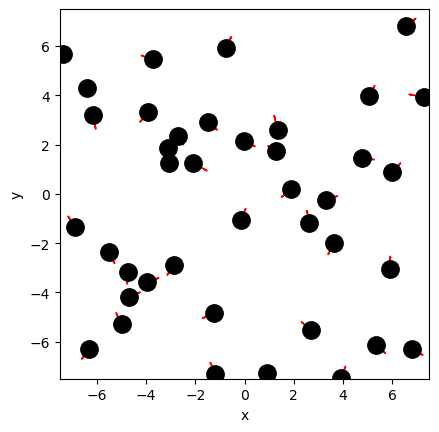

In [77]:
particles = []
create_particles(particles)
for i in range(100):
    take_time_step(particles)

plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal')
plt.xlim(-BOX_SIZE_0/2, BOX_SIZE_0/2)
plt.ylim(-BOX_SIZE_0/2, BOX_SIZE_0/2)

for p in particles:
    plt.plot(p.r[0], p.r[1], 'k.', ms=25)
    plt.arrow(p.r[0], p.r[1], p.v[0], p.v[1], 
              head_width=0.05, head_length=0.1, color='red')
plt.show()

In [79]:
print("Simulatie wordt gestart voor 100 tijdstappen...")

particles = []
create_particles(particles)

# Data opslag
energy_history = []
momentum_x_history = []
momentum_y_history = []
time_steps = list(range(100))

for step in time_steps:
    take_time_step(particles)
    
    # Bereken totale energie en impuls
    total_E = sum(p.kin_energy for p in particles)
    total_P = sum(p.momentum for p in particles)
    
    energy_history.append(total_E)
    momentum_x_history.append(total_P[0])
    momentum_y_history.append(total_P[1])

Simulatie wordt gestart voor 100 tijdstappen...


### Toevoegen animatie

Zoals gezegd: het kost veel meer rekenkracht om een animatie te maken over de tijd. Soms kan het wel helpen om te zien of de simulatie aan alle verwachtingen voldoet. 

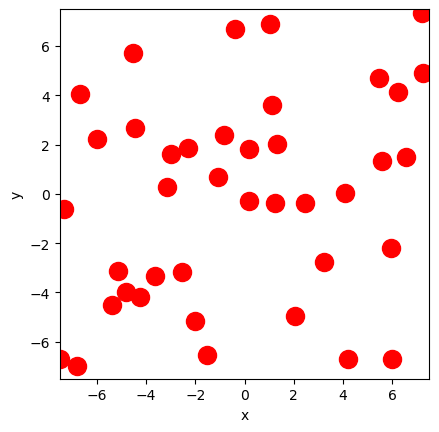

In [78]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-BOX_SIZE_0/2, BOX_SIZE_0/2)
ax.set_ylim(-BOX_SIZE_0/2, BOX_SIZE_0/2)
ax.set_aspect('equal')
dot, = ax.plot([], [], 'ro', ms=13);

def init():
    dot.set_data([], [])
    return dot,

def update(frame):
    take_time_step(particles)
    dot.set_data([p.r[0] for p in particles], [p.r[1] for p in particles])
    return dot,

ani = FuncAnimation(fig, update, frames=100, init_func=init, blit=True, interval=50)
HTML(ani.to_jshtml())

### Controle code

Om te controleren of onze code werkt passen we nu de code aan.

```{exercise}
Voeg aan de simulatie een regel toe die voor elke tijdstap bepaalt wat de totale kinetische energie is voor alle deeltjes en neem deze waarde op in een array die bij elke tijdstap met één element groeit in lengte. Maak een plot van de totale kinetische energie als functie van de tijd gedurende een simulatie van 100 tijdstappen.
```

```{exercise}
:label: ex-recap-6

Maak een plot van de totale kinetische energie als functie van de tijd gedurende een simulatie van 100 tijdstappen.
```

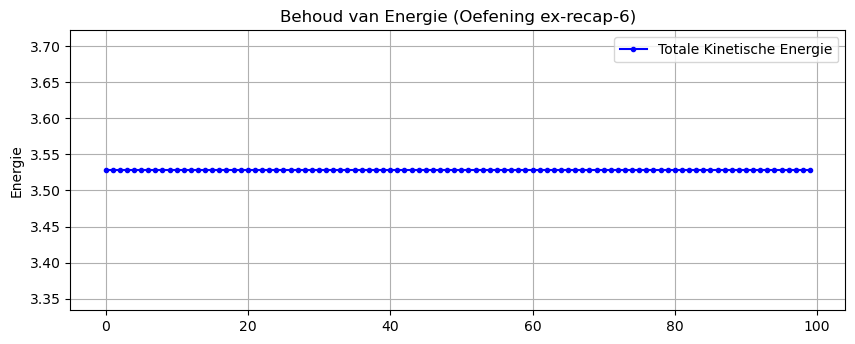

In [81]:

# Plot 1: Kinetische Energie
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(time_steps, energy_history, 'b.-', label='Totale Kinetische Energie')
plt.ylabel('Energie')
plt.title('Behoud van Energie (Oefening ex-recap-6)')
plt.grid(True)
plt.legend()

```{exercise} 
:label: error_energy
Als je heel nauwkeurig naar de waarde voor de totale kinetische energie kijkt, dan varieert deze toch. Zoom hiervoor goed in op de as voor de energie. Op welke energieschaal gebeurt dit en is de oorzaak?
```

```{solution} error_energy
Als je heel ver inzoomt op de grafiek van de totale kinetische energie, zul je zien dat de waarde niet exact constant blijft, ook al is de botsing wiskundig gezien perfect elastisch.


De variaties treden op een extreem kleine schaal op, meestal rond de 10^-14 tot 10^-16. Dat wil zeggen dat als de totale energie van je systeem ongeveer 3,5 eenheden is, dan zijn de schommelingen pas zichtbaar in het 14e of 15e cijfer achter de komma.

De oorzaak of oorzaken zijn:
-Afroundingsfouten: Bij elke berekening—zoals het optellen van posities, het berekenen van de wortel voor de snelheid, of het uitvoeren van een inproduct bij een botsing—ontstaan er minuscule afrondingsfoutjes. Over veel tijdstappen en botsingen heen tellen deze kleine verschillen op.

-Discrete tijdstap en overlap: In de simulatie bewegen deeltjes in stapjes van DT. Hierdoor stappen deeltjes vaak een klein stukje over elkaars rand heen voordat de computer de botsing detecteert. Hoewel de formule voor particle_collision de snelheden perfect aanpast op basis van de wet van behoud van energie, zorgt de minieme overlap (en de numerieke verwerking daarvan) voor heel kleine afwijkingen in de uiteindelijke berekening van de kinetische energie per deeltje.

Dus, in een theoretisch model is de energie perfect behouden, maar in een numerieke computersimulatie zorgt de beperkte rekenprecisie van de processor voor deze "ruis" op microscopisch niveau.
```

```{exercise}
:label: more_error
Noem nog een andere grootheid die behouden moet zijn. Geef ook van deze grootheid een plot van de waarde gedurende 100 tijdstappen. Zoom ook hier goed in. Is hier een variatie en zo ja, waardoor?
```



Grafieken gegenereerd.
----------------------------------------


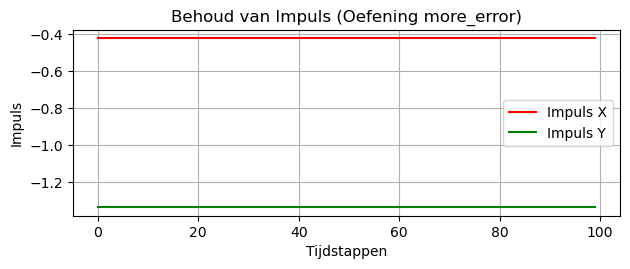

In [86]:

# Plot 2: Impuls (Oefening: more_error)
plt.subplot(2, 1, 2)
plt.plot(time_steps, momentum_x_history, 'r-', label='Impuls X')
plt.plot(time_steps, momentum_y_history, 'g-', label='Impuls Y')
plt.xlabel('Tijdstappen')
plt.ylabel('Impuls')
plt.title('Behoud van Impuls (Oefening more_error)')
plt.grid(True)
plt.legend()

plt.tight_layout()
print("Grafieken gegenereerd.")
print("-" * 40)


In [87]:
# 6. Antwoorden op Inzichtsvragen
# =============================================================================

print("--- Antwoorden op Vragen ---")
print("Vraag (error_energy): Waarom varieert de energie als je inzoomt?")
print("Antwoord: Dit komt door afrondingsfouten (floating point errors) en de discrete tijdstap.")
print("Als deeltjes overlappen tijdens een tijdstap, is de positiecorrectie niet perfect.")
print("")
print("Vraag (more_error): Welke grootheid is nog meer behouden?")
print("Antwoord: De totale Impuls (Momentum). Door de periodieke randvoorwaarden verdwijnt er")
print("geen impuls uit het systeem; wat rechts weggaat, komt er links met dezelfde snelheid weer in.")
print("-" * 40)

--- Antwoorden op Vragen ---
Vraag (error_energy): Waarom varieert de energie als je inzoomt?
Antwoord: Dit komt door afrondingsfouten (floating point errors) en de discrete tijdstap.
Als deeltjes overlappen tijdens een tijdstap, is de positiecorrectie niet perfect.

Vraag (more_error): Welke grootheid is nog meer behouden?
Antwoord: De totale Impuls (Momentum). Door de periodieke randvoorwaarden verdwijnt er
geen impuls uit het systeem; wat rechts weggaat, komt er links met dezelfde snelheid weer in.
----------------------------------------


In [88]:
# 7. De 'Peper' Opdracht: Simultane Botsingen (ex-recap-9)
# =============================================================================
print("--- Simulatie: 3-Deeltjes Probleem (Peper Opdracht) ---")
print("We testen wat er gebeurt als 3 deeltjes tegelijk botsen.")


--- Simulatie: 3-Deeltjes Probleem (Peper Opdracht) ---
We testen wat er gebeurt als 3 deeltjes tegelijk botsen.


In [89]:
# Setup: 3 deeltjes op een lijn die tegelijk zouden moeten botsen
# P1 gaat naar rechts, P2 staat stil, P3 gaat naar links
p_test = []
p_test.append(ParticleClass(m=1, v=[1, 0], r=[-0.29, 0], R=0.3)) # P1
p_test.append(ParticleClass(m=1, v=[0, 0], r=[0, 0],    R=0.3)) # P2 (Midden)
p_test.append(ParticleClass(m=1, v=[-1, 0], r=[0.29, 0], R=0.3)) # P3

print("Snelheden VOOR botsingdetectie:")
for i, p in enumerate(p_test):
    print(f"P{i}: v={p.v}")

handle_collisions(p_test)

print("Snelheden NA botsingdetectie (Sequentieel):")
for i, p in enumerate(p_test):
    print(f"P{i}: v={p.v}")

print("\nConclusie:")
print("Omdat de code sequentieel werkt (eerst paar P0-P1, dan P0-P2, dan P1-P2),")
print("wordt de botsing niet als een gelijktijdige 3-deeltjes interactie berekend.")
print("P0 botst met P1, verandert van snelheid, en daarna wordt pas gekeken naar P1 en P2.")
print("Voor ijle gassen is dit acceptabel omdat 3-deeltjes botsingen zeldzaam zijn.")

plt.show()

Snelheden VOOR botsingdetectie:
P0: v=[1. 0.]
P1: v=[0. 0.]
P2: v=[-1.  0.]
Snelheden NA botsingdetectie (Sequentieel):
P0: v=[-1.  0.]
P1: v=[0. 0.]
P2: v=[1. 0.]

Conclusie:
Omdat de code sequentieel werkt (eerst paar P0-P1, dan P0-P2, dan P1-P2),
wordt de botsing niet als een gelijktijdige 3-deeltjes interactie berekend.
P0 botst met P1, verandert van snelheid, en daarna wordt pas gekeken naar P1 en P2.
Voor ijle gassen is dit acceptabel omdat 3-deeltjes botsingen zeldzaam zijn.



Voor simulaties waarbij de kans op botsingen heel groot is (richting vloeistof), is er een handige methode om de snelheid van je simulatie op te voeren.
In onderstaande code wordt daar een voorbeeld van gegeven.

```{code} python
def handle_collisions(particles):
    """ alle onderlinge botsingen afhandelen voor deeltjes in lijst """
    num_particles = len(particles)
    for i in range(num_particles):
        for j in range(i+1, num_particles):
            if collide_detection(particles[i], particles[j]):
                particle_collision(particles[i], particles[j])
```

```{exercise} Controleren van beperkingen 🌶 
:label: ex-recap-9

Leg uit wat deze code precies doet. 

Maak een script waarbij twee deeltjes met dezelfde (absolute) snelheid op een derde deeltje afbewegen en tegelijk zouden botsen.
- Laat zien dat 'slechts' twee deeltjes een interactie met elkaar aan gaan.
- Leg uit waarom dat een acceptabele benadering is wanneer je veel deeltjes botsingen per tijdseenheid hebt.
- Voor wie een uitdaging wil: maak een grafiek met het aantal botsingen per tijdseenheid. Dit om bovenstaande benadering verder te verantwoorden.
```

````{tip} Nog sneller
Er is een manier om je script nog sneller te maken. 
Die methode gaat wel voorbij aan wat we verwachten van eerstejaars, maar het idee is de moeite waard om te bekijken.
Bij $N$ deeltjes zou je $\frac{N(N-1)}{2}$ mogelijke botsingen moeten bekijken. 
Door gebruik te maken van een ignore list maak je die mogelijk aantal botsingen al een stuk minder.
Maar je zou ook er van uit kunnen gaan dat botsingen slechts plaats vinden met deeltjes die in de buurt zijn.
Als je een grid maakt en elk deeltje in een grid zet, hoeft elk deeltje slechts in de naastgelegen velden te "kijken" of daar een deeltje aanwezig is waarmee een botsing kan plaats vinden.

In onderstaande figuur is dat weergegeven. 
Het lichtrode deeltje heeft potentieel maar negen mogelijke botsingen. 
Dat script kan verder geoptimaliseerd worden door van links naar rechts per grid te lopen, dan hoeven zelfs niet alle velden bekeken te worden.

```{figure} ../../Figures/grid.png
:width: 50%
```

````

Antwoord:
Als drie deeltjes tegelijkertijd samenkomen, zal de handle_collisions functie ze na elkaar verwerken (bijvoorbeeld eerst A met B, en daarna de nieuwe B met C).

In de werkelijkheid zouden de krachten van alle drie de deeltjes gelijktijdig op elkaar inwerken. Hoewel onze methode een benadering is, is de kans dat drie deeltjes in een ijl gas exact op hetzelfde moment op dezelfde plek zijn extreem klein. Voor dit model is de paarsgewijze afhandeling daarom nauwkeurig genoeg.

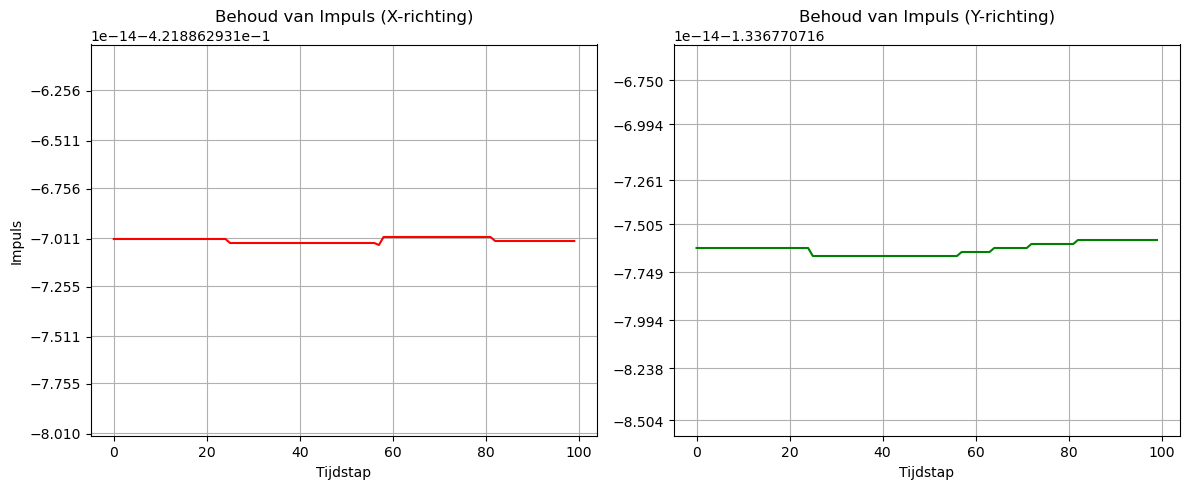

In [90]:
# 1. Data verzamelen over 100 tijdstappen
px_history = []
py_history = []
time_steps = range(100)

for _ in time_steps:
    take_time_step(particles)
    # Bereken de vector-som van de impuls (m*v)
    total_P = np.sum([p.momentum for p in particles], axis=0)
    px_history.append(total_P[0])
    py_history.append(total_P[1])

# 2. Plotten van de resultaten
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(time_steps, px_history, color='red', label='Totale Px')
plt.title("Behoud van Impuls (X-richting)")
plt.xlabel("Tijdstap")
plt.ylabel("Impuls")
# Zoom extreem in om de floating point variatie te zien
plt.ylim(np.mean(px_history)-1e-14, np.mean(px_history)+1e-14)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(time_steps, py_history, color='green', label='Totale Py')
plt.title("Behoud van Impuls (Y-richting)")
plt.xlabel("Tijdstap")
plt.ylim(np.mean(py_history)-1e-14, np.mean(py_history)+1e-14)
plt.grid(True)

plt.tight_layout()
plt.show()

In de volgende notebooks maken we veelal gebruik van numpy functies.
In sommige gevallen is dat sneller, maar lang niet altijd.
Het is good-practice om na te gaan wat sneller is.
Aan de andere kant moet de tekst ook leesbaar blijven...

Als onderdeel om excellent te scoren verwachten we dat je een aantal checks tussendoor doet om code sneller te maken.
In onderstaande testcode, gemaakt door Josh Sleijfer wordt een van die functies getest.
Wat blijkt?
Voor "kleine" vectoren is het sneller om geen gebruik te maken van Numpy maar voor grotere vectoren wel!

```{code} python
import numpy as np
import time

L = 2                # lengte van de vector
repeats = 1_000_000  # aantal herhalingen

rnd_vec1 = np.random.rand(L, repeats)
 
# test numpy dot product
t0 = time.perf_counter()
for vec1 in rnd_vec1.T:
    dot = np.dot(vec1, vec1)
t1 = time.perf_counter()

print(f"Numpy: Time taken for {repeats} dot products of length {L}: {t1 - t0:.4f} seconds")

# test no numpy dot product 
t0 = time.perf_counter()
for vec1 in rnd_vec1.T:
    dot = vec1[0] * vec1[0] + vec1[1] * vec1[1] # + vec1[2] * vec1[2] + vec1[3] * vec1[3] # don't forget to adjust!
t1 = time.perf_counter()

print(f"No Numpy: Time taken for {repeats} dot products of length {L}: {t1 - t0:.4f} seconds")

# test fully vectorized 
t0 = time.perf_counter()
dot = np.sum(rnd_vec1[0] * rnd_vec1[0] + rnd_vec1[1] * rnd_vec1[1])
t1 = time.perf_counter()
print(f"Fully vectorized: Time taken for {repeats} dot products of length {L}: {t1 - t0:.4f} seconds")

```

```{exercise}
Laat je werk aftekenen door een TA
```